##### import all the dependencies

In [28]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

##### read data

In [ ]:
file_path = "../data/TabularData/riceClassification.csv"
data_df = pd.read_csv(file_path)

In [30]:
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


##### clean and process data

In [31]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1,inplace=True)
print(data_df.shape)

(18185, 11)


In [32]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [33]:
print(data_df["Class"].unique())

[1 0]


In [34]:
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [35]:
original_df  = data_df.copy()

In [36]:
for column in data_df.columns:
    data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [37]:
X = np.array(data_df.iloc[:, :-1])
Y = np.array(data_df.iloc[:, -1])


In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)


In [39]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(12729, 10)
(2728, 10)
(12729,)
(2728,)
(2728, 10)
(2728,)


In [40]:
print(X.shape[1])

10


##### hyperparameter

In [41]:
BATCH_SIZE = 8
EPOCHS = 100
HIDDEN_NEURONS = 10
LR = 1e-3

##### create dataset

In [42]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X) # shape of the input
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [43]:
training_data = dataset(X_train, Y_train)
validation_data = dataset(X_val, Y_val)
testing_data = dataset(X_test, Y_test)

In [44]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

##### create model

In [45]:

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel().to(device)    

In [46]:
summary(model, (X.shape[1], ))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 10]                  110
├─Linear: 1-2                            [-1, 1]                   11
├─Sigmoid: 1-3                           [-1, 1]                   --
Total params: 121
Trainable params: 121
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 10]                  110
├─Linear: 1-2                            [-1, 1]                   11
├─Sigmoid: 1-3                           [-1, 1]                   --
Total params: 121
Trainable params: 121
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [47]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=LR)

In [48]:
total_loss_train_plot = []
total_acc_train_plot = []

total_loss_validation_plot = []
total_acc_validation_plot = []

##### training loop and validation

In [49]:
def train(model, train_dataloader , criterion, optimizer, EPOCHS):
    model.train()

    for epoch in range(EPOCHS):
        total_acc_train = 0
        total_loss_train = 0

        for data in train_dataloader:
            inputs, labels = data
            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)
            total_loss_train += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        total_loss_train_plot.append(round(total_loss_train/1000, 4))
        total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    
        print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f}''')
        print("="*50)

        validation(model, validation_dataloader)

def validation(model, validation_dataloader):
    model.eval()

    total_acc_val = 0
    total_loss_val = 0

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data
            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)
            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()
            total_acc_val += acc

    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_validation_plot.append(round(total_acc_val / len(validation_dataloader.dataset) * 100, 4))

    print(f'''Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val / len(validation_dataloader.dataset) * 100):.4f}''')
    print("="*50)  
            


##### training model

In [50]:
# train the model
train(model, train_dataloader, criterion, optimizer, EPOCHS)

Epoch no. 1 Train Loss: 0.6989 Train Accuracy: 88.4516
Validation Loss: 0.2702 Validation Accuracy: 97.7846
Epoch no. 2 Train Loss: 0.1592 Train Accuracy: 98.4681
Validation Loss: 0.1062 Validation Accuracy: 98.4916
Epoch no. 3 Train Loss: 0.0911 Train Accuracy: 98.5702
Validation Loss: 0.0796 Validation Accuracy: 98.6488
Epoch no. 4 Train Loss: 0.0757 Train Accuracy: 98.5781
Validation Loss: 0.0727 Validation Accuracy: 98.5781
Epoch no. 5 Train Loss: 0.0707 Train Accuracy: 98.6252
Validation Loss: 0.0700 Validation Accuracy: 98.6016
Epoch no. 6 Train Loss: 0.0681 Train Accuracy: 98.6016
Validation Loss: 0.0658 Validation Accuracy: 98.6802
Epoch no. 7 Train Loss: 0.0682 Train Accuracy: 98.6330
Validation Loss: 0.0647 Validation Accuracy: 98.6488
Epoch no. 8 Train Loss: 0.0670 Train Accuracy: 98.5781
Validation Loss: 0.0918 Validation Accuracy: 97.8946
Epoch no. 9 Train Loss: 0.0674 Train Accuracy: 98.5702
Validation Loss: 0.0644 Validation Accuracy: 98.6409
Epoch no. 10 Train Loss: 0.0

##### test the model

In [51]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

test_accuracy = round((total_acc_test / len(test_dataloader.dataset)) * 100, 2)
print(f"Accuracy Score is: {test_accuracy}%")

Accuracy Score is: 98.71%


##### Training and Validation Loss over Epochs and Training and Validation Accuracy over Epochs plots

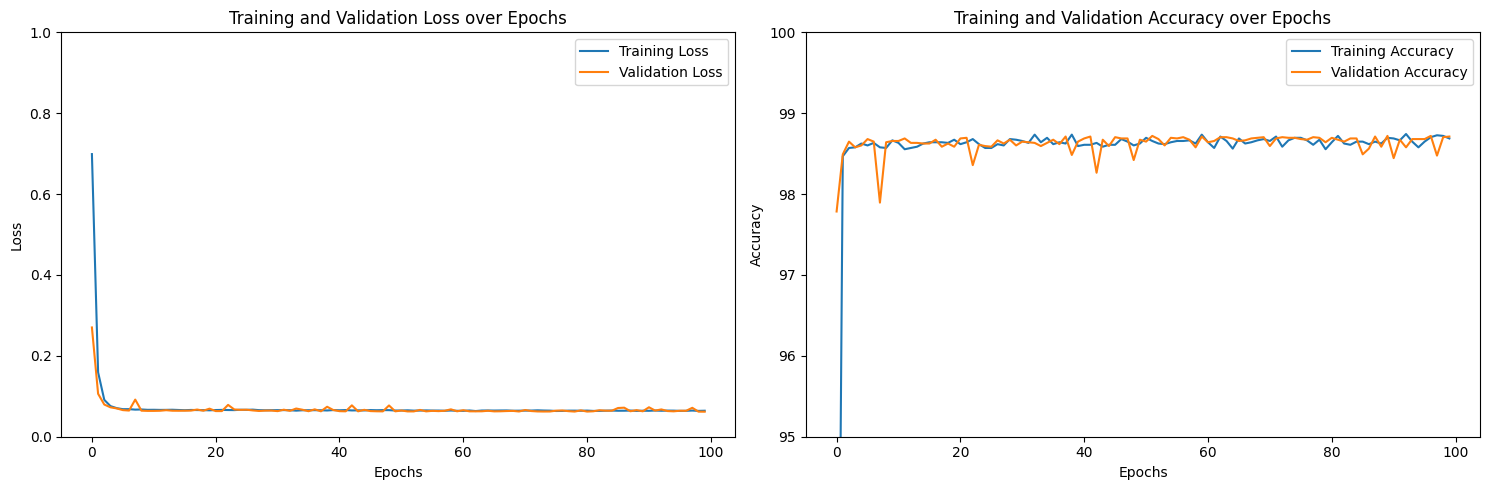

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([95, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [56]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

tensor([0.], grad_fn=<SigmoidBackward0>)
Class is:  0


#### save the model

In [54]:
save_file_path = "../models/"
torch.save(model.state_dict(), f"{save_file_path}TDC_model.pth")
print("Model saved successfully!")

Model saved successfully!
